# Data Science Task - NLP with Tensorflow


Use Tensorflow to compare performances of a pretrained model vs. a basic model from scratch by you, then offer your opinions (not to build) how you can improve your custom-built model performance.


 __Requirements__:

1. Pick a text (NLP) dataset or image/text (CNN/NLP) dataset of your choice from here:
https://github.com/tensorflow/datasets
2. Pick one of the pretrained models to do a transfer learning on your dataset: https://tfhub.dev/
3. Describe the purpose of the model, show the model architecture and performance (two metrics of your choice)
4. Please choose a problem directly related to your work experience
5. Now, build your own model in tensorflow from scratch to solve the same problem based on your work experience, show the model architecture and performance (two same metrics used from step 3) – note that a model from scratch should have significantly poorer model performance due to time/computing resource constraints, and limited training dataset 
6. I am more interested in how you would design the model architect and why, not the model performance
7. Offer your opinions, in a few bullet points or short sentences, steps you can take (you do not have to build the model) to improve your own model to get to a closer power as the pretrained model

## Sentiment analysis

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow_datasets as tfds
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_hub as hub

In [2]:
# import os
# os.chdir("/Volumes/Work/DS projects/Sentiment Analysis")

__Data__:
Movie Review dataset was from "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz".  The compiled .csv data file was downloaded and saved in the working directory of this jupyter notebook

In [3]:
dataset = pd.read_csv('./data/IMDB Dataset.csv')
negative = len(dataset[dataset['sentiment']=='positive'])
positive = len(dataset) - negative
print("%d positive reviews, %d negative reviews, %d in total" %(positive, negative, len(dataset)))

25000 positive reviews, 25000 negative reviews, 50000 in total


__Pre-Processing the text__

In [4]:
le = LabelEncoder()
training_reviews,testing_reviews,training_labels,testing_labels  = train_test_split(dataset['review'].values,dataset['sentiment'].values,test_size = 0.2)
training_labels = le.fit_transform(training_labels)
testing_labels = le.fit_transform(testing_labels)

In [5]:
tokenizer = Tokenizer(num_words=10000,oov_token='OOV')
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index
training_sequence = tokenizer.texts_to_sequences(training_reviews)
testing_sequence = tokenizer.texts_to_sequences(testing_reviews)
train_pad_sequence = pad_sequences(training_sequence,maxlen = 200,truncating= 'post',padding = 'pre')
test_pad_sequence = pad_sequences(testing_sequence,maxlen = 200,truncating= 'post',padding = 'pre')
print('Total Unique Words : {}'.format(len(word_index)))

Total Unique Words : 112146


__Build a model of sentiment analysis by use of the pre-trained wikipedia Word2Vec model__

In [6]:
embed = hub.load("https://tfhub.dev/google/Wiki-words-250/2")

In [7]:
embedding_matrix1 = np.zeros((len(word_index) + 1,250))
for word, i in word_index.items():
    embedding_vector = np.array(embed([word]))[0]
    if embedding_vector is not None:
        embedding_matrix1[i] = embedding_vector

In [8]:
embedding_matrix1.shape

(112147, 250)

In [9]:
from keras import backend as K

def recall_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [10]:
model1 = tf.keras.Sequential([tf.keras.layers.Embedding(len(word_index) + 1, 250,
                                                        weights=[embedding_matrix1],
                                                        input_length=200,
                                                        trainable=False),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(256,activation = 'relu',),
                             tf.keras.layers.Dense(128,activation = 'relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1,activation = tf.nn.sigmoid)])

In [11]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 250)          28036750  
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               161280    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [12]:
model1.compile(loss = tf.keras.losses.BinaryCrossentropy() , 
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) , 
               metrics = ['accuracy',
                           tf.keras.metrics.AUC(), 
#                            tf.keras.metrics.Precision(), 
#                            tf.keras.metrics.Recall(),
                           recall_score,
                           precision_score,
                           f1_score])

history1 = model1.fit(train_pad_sequence,training_labels,
                      epochs = 20,
                      validation_data=(test_pad_sequence,testing_labels),
                      verbose=1)

Epoch 1/20
1250/1250 [==============================] - 74s 57ms/step - loss: 0.5863 - accuracy: 0.6895 - auc: 0.7584 - recall_score: 0.6554 - precision_score: 0.7173 - f1_score: 0.6556 - val_loss: 0.5579 - val_accuracy: 0.7151 - val_auc: 0.8152 - val_recall_score: 0.5391 - val_precision_score: 0.8314 - val_f1_score: 0.6457
Epoch 2/20
1250/1250 [==============================] - 73s 58ms/step - loss: 0.4941 - accuracy: 0.7728 - auc: 0.8424 - recall_score: 0.7722 - precision_score: 0.7829 - f1_score: 0.7646 - val_loss: 0.4484 - val_accuracy: 0.7947 - val_auc: 0.8730 - val_recall_score: 0.7828 - val_precision_score: 0.8028 - val_f1_score: 0.7871
Epoch 3/20
1250/1250 [==============================] - 80s 64ms/step - loss: 0.4981 - accuracy: 0.7624 - auc: 0.8395 - recall_score: 0.7730 - precision_score: 0.7695 - f1_score: 0.7573 - val_loss: 0.4547 - val_accuracy: 0.7823 - val_auc: 0.8846 - val_recall_score: 0.9066 - val_precision_score: 0.7272 - val_f1_score: 0.8024
Epoch 4/20
1250/1250 [

In [13]:
history1.history.items()

dict_items([('loss', [0.5862730145454407, 0.49413740634918213, 0.49811679124832153, 0.437511682510376, 0.40879666805267334, 0.38156658411026, 0.36229628324508667, 0.3500630557537079, 0.33714431524276733, 0.32848426699638367, 0.31750884652137756, 0.31204771995544434, 0.3006991744041443, 0.2930067181587219, 0.2864946722984314, 0.2770780622959137, 0.271226167678833, 0.26107627153396606, 0.25394749641418457, 0.24669799208641052]), ('accuracy', [0.6894500255584717, 0.7728000283241272, 0.7623999714851379, 0.8059499859809875, 0.8202250003814697, 0.8360999822616577, 0.8443499803543091, 0.8510000109672546, 0.8569250106811523, 0.8630750179290771, 0.8664500117301941, 0.8672000169754028, 0.8747749924659729, 0.8780500292778015, 0.8816249966621399, 0.8860250115394592, 0.8886250257492065, 0.8915749788284302, 0.8946250081062317, 0.9001500010490417]), ('auc', [0.7583937644958496, 0.8424305319786072, 0.839506208896637, 0.8803722858428955, 0.8964293599128723, 0.9105474948883057, 0.9195422530174255, 0.925

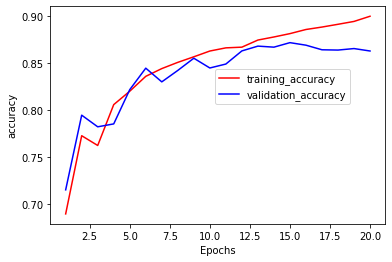

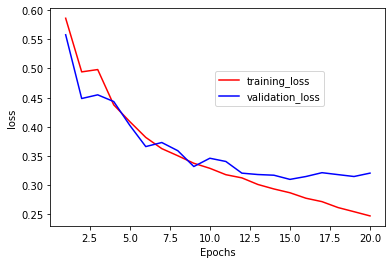

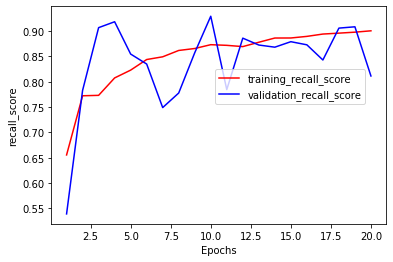

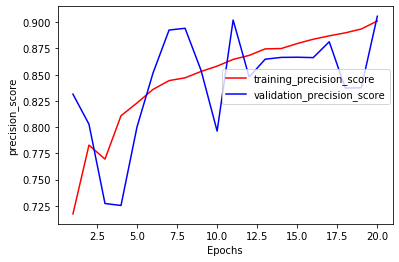

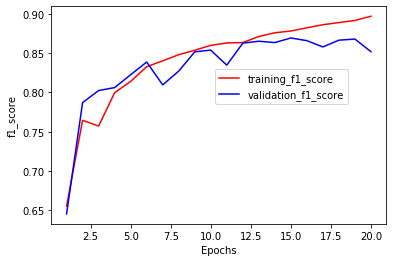

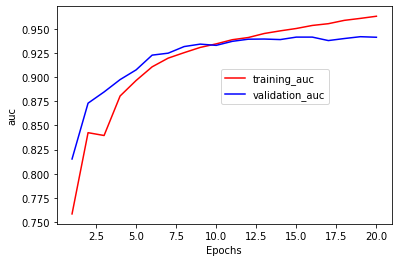

In [16]:
def plot_graphs(history, metric):
  x=[int(i+1) for i in range(len(history.history[metric]))]
  plt.plot(x, history.history[metric], 'r', label='training_'+metric)
  plt.plot(x, history.history['val_'+metric], 'b', label='validation_'+metric)
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend(loc=[0.49, 0.55])
  plt.show()
  
#check your metrics  
plot_graphs(history1, 'accuracy')
plot_graphs(history1, 'loss')
plot_graphs(history1, 'recall_score')
plot_graphs(history1, 'precision_score')
plot_graphs(history1, 'f1_score')
plot_graphs(history1, 'auc')

In [22]:
print('F1 score is %.3f for training, and %.3f for validation ' 
      % (history1.history['f1_score'][11], history1.history['val_f1_score'][11]))

print('AUC-ROC is %.3f for training, and %.3f for validation ' 
      % (history1.history['auc'][11], history1.history['val_auc'][11]))

F1 score is 0.863 for training, and 0.863 for validation 
AUC-ROC is 0.941 for training, and 0.939 for validation 


__Build a model of sentiment analysi by use of the pre-trained GloVe model__

In [16]:
embedded_words = {}
with open('./data/glove.6B.200d.txt') as file:
    for line in file:
        words, coeff = line.split(maxsplit=1)
        coeff = np.array(coeff.split(),dtype = float)
        embedded_words[words] = coeff

In [17]:
embedding_matrix2 = np.zeros((len(word_index) + 1,200))
for word, i in word_index.items():
    embedding_vector = embedded_words.get(word)
    if embedding_vector is not None:
        embedding_matrix2[i] = embedding_vector

In [18]:
model2 = tf.keras.Sequential([tf.keras.layers.Embedding(len(word_index) + 1, 200,
                                                        weights=[embedding_matrix2],
                                                        input_length=200,
                                                        trainable=False),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(256,activation = 'relu',),
                             tf.keras.layers.Dense(128,activation = 'relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1,activation = tf.nn.sigmoid)])

In [19]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 200)          22455600  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               135680    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [20]:
model2.compile(loss = tf.keras.losses.BinaryCrossentropy() , 
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) , 
               metrics = ['accuracy',
                           tf.keras.metrics.AUC(), 
#                            tf.keras.metrics.Precision(), 
#                            tf.keras.metrics.Recall(),
                           recall_score,
                           precision_score,
                           f1_score])

history2 = model2.fit(train_pad_sequence,training_labels,
                      epochs = 20,
                      validation_data=(test_pad_sequence,testing_labels),
                      verbose=1)

Epoch 1/20
1250/1250 [==============================] - 77s 60ms/step - loss: 0.5569 - accuracy: 0.6985 - auc_1: 0.7820 - recall_score: 0.6959 - precision_score: 0.7082 - f1_score: 0.6786 - val_loss: 0.3920 - val_accuracy: 0.8185 - val_auc_1: 0.9104 - val_recall_score: 0.9006 - val_precision_score: 0.7722 - val_f1_score: 0.8275
Epoch 2/20
1250/1250 [==============================] - 77s 61ms/step - loss: 0.3710 - accuracy: 0.8396 - auc_1: 0.9161 - recall_score: 0.8422 - precision_score: 0.8398 - f1_score: 0.8352 - val_loss: 0.3548 - val_accuracy: 0.8475 - val_auc_1: 0.9328 - val_recall_score: 0.7781 - val_precision_score: 0.9025 - val_f1_score: 0.8311
Epoch 3/20
1250/1250 [==============================] - 76s 61ms/step - loss: 0.3336 - accuracy: 0.8597 - auc_1: 0.9322 - recall_score: 0.8645 - precision_score: 0.8577 - f1_score: 0.8561 - val_loss: 0.3173 - val_accuracy: 0.8670 - val_auc_1: 0.9409 - val_recall_score: 0.8879 - val_precision_score: 0.8515 - val_f1_score: 0.8658
Epoch 4/20

In [21]:
history2.history.items()

dict_items([('loss', [0.5568873286247253, 0.37103545665740967, 0.3335936665534973, 0.3086208701133728, 0.28715792298316956, 0.26489579677581787, 0.24737079441547394, 0.22585712373256683, 0.20437242090702057, 0.18502791225910187, 0.16328510642051697, 0.14801697432994843, 0.12945814430713654, 0.11429859697818756, 0.10112541168928146, 0.08816491067409515, 0.07706194370985031, 0.07191339135169983, 0.06725174933671951, 0.05956510454416275]), ('accuracy', [0.6984999775886536, 0.8396250009536743, 0.8597249984741211, 0.8729749917984009, 0.8786500096321106, 0.8910999894142151, 0.8991000056266785, 0.9081249833106995, 0.9178749918937683, 0.9270250201225281, 0.9373499751091003, 0.9429749846458435, 0.9511749744415283, 0.9577249884605408, 0.9625499844551086, 0.9667750000953674, 0.9718499779701233, 0.9746249914169312, 0.9761999845504761, 0.9793499708175659]), ('auc_1', [0.782046377658844, 0.9160861968994141, 0.9322227835655212, 0.9421548843383789, 0.9498872756958008, 0.9574301242828369, 0.96265238523

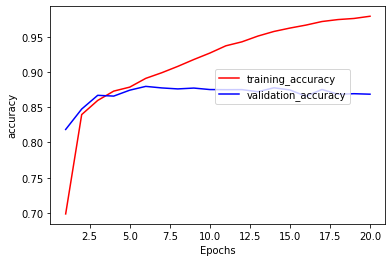

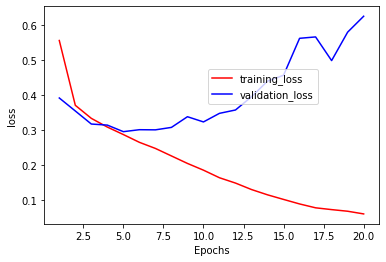

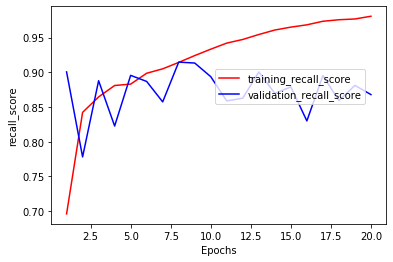

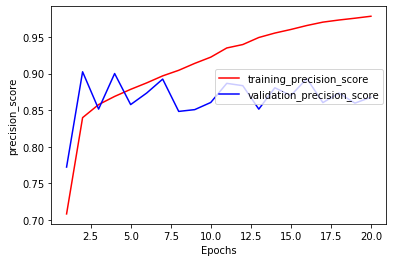

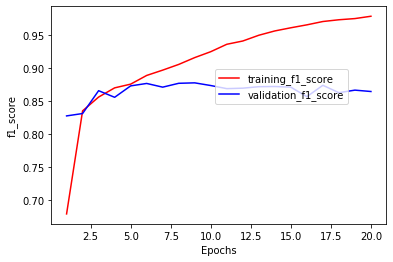

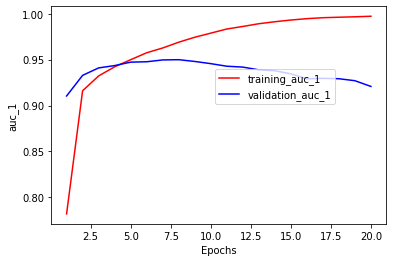

In [35]:
#check your metrics  
plot_graphs(history2, 'accuracy')
plot_graphs(history2, 'loss')
plot_graphs(history2, 'recall_score')
plot_graphs(history2, 'precision_score')
plot_graphs(history2, 'f1_score')
plot_graphs(history2, 'auc_1')

In [40]:
print('F1 score is %.3f for training, and %.3f for validation ' 
      % (history2.history['f1_score'][4], history2.history['val_f1_score'][4]))

print('AUC-ROC is %.3f for training, and %.3f for validation ' 
      % (history2.history['auc_1'][4], history2.history['val_auc_1'][4]))

F1 score is 0.876 for training, and 0.873 for validation 
AUC-ROC is 0.950 for training, and 0.947 for validation 


__Build a model of sentiment analysis by use of custome embedding (i.e. not pre-trained)__


In [39]:
model3 = tf.keras.Sequential([tf.keras.layers.Embedding(len(word_index) + 1, 250, input_length=200),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(256,activation = 'relu',),
                             tf.keras.layers.Dense(128,activation = 'relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1,activation = tf.nn.sigmoid)])

In [25]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 250)          28069500  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               161280    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [26]:
model3.compile(loss = tf.keras.losses.BinaryCrossentropy() , 
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) , 
               metrics = ['accuracy',
                           tf.keras.metrics.AUC(), 
#                            tf.keras.metrics.Precision(), 
#                            tf.keras.metrics.Recall(),
                           recall_score,
                           precision_score,
                           f1_score])

history3 = model3.fit(train_pad_sequence,training_labels,
                      epochs = 20 ,
                      validation_data=(test_pad_sequence,testing_labels),
                      verbose=1)

Epoch 1/20
1250/1250 [==============================] - 454s 361ms/step - loss: 0.4505 - accuracy: 0.7894 - auc_2: 0.8723 - recall_score: 0.8133 - precision_score: 0.7910 - f1_score: 0.7867 - val_loss: 0.3429 - val_accuracy: 0.8494 - val_auc_2: 0.9386 - val_recall_score: 0.7578 - val_precision_score: 0.9306 - val_f1_score: 0.8298
Epoch 2/20
1250/1250 [==============================] - 449s 359ms/step - loss: 0.2869 - accuracy: 0.8893 - auc_2: 0.9495 - recall_score: 0.8946 - precision_score: 0.8873 - f1_score: 0.8864 - val_loss: 0.3260 - val_accuracy: 0.8777 - val_auc_2: 0.9467 - val_recall_score: 0.9073 - val_precision_score: 0.8564 - val_f1_score: 0.8778
Epoch 3/20
1250/1250 [==============================] - 447s 358ms/step - loss: 0.2208 - accuracy: 0.9168 - auc_2: 0.9697 - recall_score: 0.9225 - precision_score: 0.9139 - f1_score: 0.9148 - val_loss: 0.3189 - val_accuracy: 0.8764 - val_auc_2: 0.9439 - val_recall_score: 0.8874 - val_precision_score: 0.8684 - val_f1_score: 0.8744
Epoc

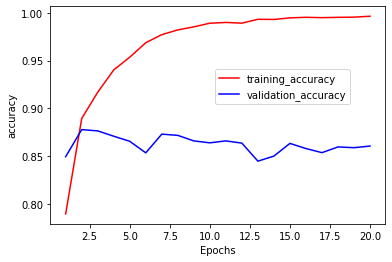

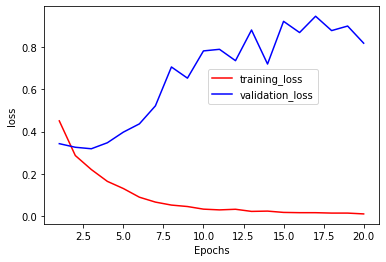

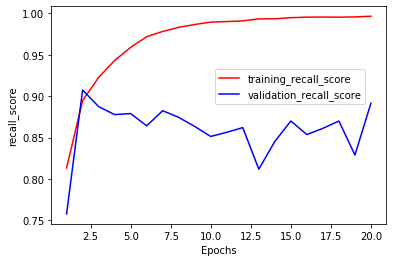

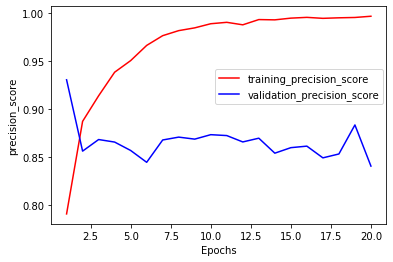

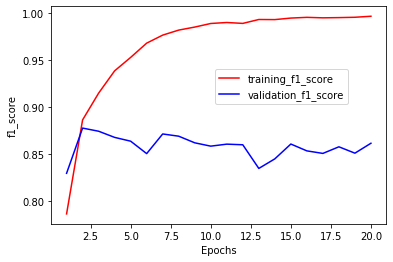

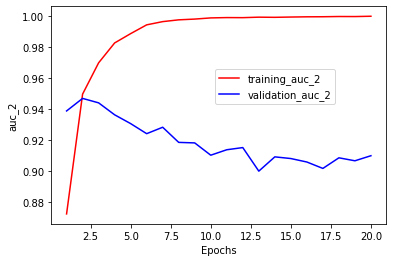

In [33]:
#check your metrics  
plot_graphs(history3, 'accuracy')
plot_graphs(history3, 'loss')
plot_graphs(history3, 'recall_score')
plot_graphs(history3, 'precision_score')
plot_graphs(history3, 'f1_score')
plot_graphs(history3, 'auc_2')

In [34]:
print('F1 score is %.3f for training, and %.3f for validation' 
      % (history3.history['f1_score'][1], history3.history['val_f1_score'][1]))

print('AUC-ROC is %.3f for training, and %.3f for validation' 
      % (history3.history['auc_2'][1], history3.history['val_auc_2'][1]))

F1 score is 0.886 for training, and 0.878 for validation
AUC-ROC is 0.949 for training, and 0.947 for validation
